In [151]:
import pylab as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
#import proposal as pp  #installed with pip
import scipy
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp2d
import scipy.integrate as integrate
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import re
import sys
import glob
#from MCEq.core import config, MCEqRun
#import crflux.models as crf
import random
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [2]:
CLRS=["gray","firebrick","orchid","deepskyblue","orange","blueviolet","magenta","limegreen","pink","tomato","red","black","yellow","darkgreen"]

energies=[100,250,500,750,1000,1500,2000,3000,4000,5000,6000,7500,8500,10000,11000,12500,15000,20000,25000]
GeV=1000

NumToRun=1000

AreaOfNextNEW=np.pi*(45/2)**2*66 #cm^2 but these dimensions need double checked

In [4]:
#MCeQ outputs with Phi
r=0

for files in glob.glob('./MCeQdataPlusProposal/AIRSdensity/*'):
    #print (files,re.search('Muons(.*)degrees', files))
    run=re.search('Muons(.*)degrees', files)
    ths=int(run.group(1))
    if r==0:
        mussimData=pd.read_hdf(files)
        mussimData['theta']=    ths
        r+=1
    else:
        df=pd.read_hdf(files)
        df['theta']=ths
        mussimData=mussimData.append(df, ignore_index=True)
        
mussimData['altitude']=mussimData.altitude*10**-2    
alpharange=mussimData.theta.unique()
alpharange.sort()
betarange=mussimData.phis.unique()
betarange.sort()
print(alpharange)
mussimData=mussimData.rename(columns={"theta": "alpha", "phis":  "beta"})

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]


In [5]:
energiesrange=mussimData.Energies.unique()
energiesrange.sort
len(energiesrange)

121

In [21]:
'''E=energiesrange[50]
inteAs=[]
inteBs=[]
inteflux=[]

for A in alpharange[::2]:
    print(A)
    for B in betarange[::15]:
        alp=np.deg2rad(A)
        bet=np.deg2rad(B)
        inteAs.append(np.cos(alp))
        inteBs.append(bet)
        
        FLUX=mussimData[(mussimData.alpha==A)&(mussimData.beta==B)&(mussimData.Energies==E)].MuFLux.iloc[0]
        inteflux.append(FLUX)
        

inteflux = np.array(inteflux)
inteflux=inteflux.reshape(len(np.unique(inteAs)), len(np.unique(inteBs)))


        '''

'E=energiesrange[50]\ninteAs=[]\ninteBs=[]\ninteflux=[]\n\nfor A in alpharange[::2]:\n    print(A)\n    for B in betarange[::15]:\n        alp=np.deg2rad(A)\n        bet=np.deg2rad(B)\n        inteAs.append(np.cos(alp))\n        inteBs.append(bet)\n        \n        FLUX=mussimData[(mussimData.alpha==A)&(mussimData.beta==B)&(mussimData.Energies==E)].MuFLux.iloc[0]\n        inteflux.append(FLUX)\n        \n\ninteflux = np.array(inteflux)\ninteflux=inteflux.reshape(len(np.unique(inteAs)), len(np.unique(inteBs)))\n\n\n        '

In [22]:
'''

fig, (ax) = plt.subplots(1, 1,figsize=(9,8))

cmap = plt.get_cmap('PiYG')
c=ax.pcolormesh(np.unique(inteAs),np.unique(inteBs),np.transpose(inteflux),cmap=cmap.reversed(),shading='auto',vmin=0)



clb=fig.colorbar(c, ax=ax)
clb.ax.tick_params(labelsize=18) 

clb.ax.set_ylabel('MuonFlux'+ r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}$) (GeV)', rotation=270,fontsize=18, labelpad=15)

plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 

plt.ylim(-np.pi,np.pi)
plt.xlim(0,1)

plt.ylabel('Azimuth',fontsize=18)
plt.xlabel('cos(zenith)',fontsize=18)
plt.tight_layout()
#plt.savefig('efficiency.png',dpi=250,bbox_inches='tight')
plt.show()'''

"\n\nfig, (ax) = plt.subplots(1, 1,figsize=(9,8))\n\ncmap = plt.get_cmap('PiYG')\nc=ax.pcolormesh(np.unique(inteAs),np.unique(inteBs),np.transpose(inteflux),cmap=cmap.reversed(),shading='auto',vmin=0)\n\n\n\nclb=fig.colorbar(c, ax=ax)\nclb.ax.tick_params(labelsize=18) \n\nclb.ax.set_ylabel('MuonFlux'+ r'$(E/ {GeV})^3\\,\\Phi (GeV cm^{-2}\\,$s$^{-1}$) (GeV)', rotation=270,fontsize=18, labelpad=15)\n\nplt.yticks(fontsize=18)  \nplt.xticks(fontsize=18) \n\nplt.ylim(-np.pi,np.pi)\nplt.xlim(0,1)\n\nplt.ylabel('Azimuth',fontsize=18)\nplt.xlabel('cos(zenith)',fontsize=18)\nplt.tight_layout()\n#plt.savefig('efficiency.png',dpi=250,bbox_inches='tight')\nplt.show()"

In [49]:
listofpoints_alpha,listofpoints_beta=np.meshgrid(alphas, betas)

In [108]:

#These to be replaced with the real lists soon
UnitVectors=[]
listofpoints_alpha=listofpoints_alpha.flatten()
listofpoints_beta=listofpoints_beta.flatten()
d2r=np.pi/180

# Make 3D unit vectors on the sphere for each point available
for i in range(0, len(listofpoints_alpha)):
    UnitVectors.append([np.sin(listofpoints_alpha[i]*d2r)*np.cos(listofpoints_beta[i]*d2r),np.sin(listofpoints_alpha[i]*d2r)*np.sin(listofpoints_beta[i]*d2r),np.cos(listofpoints_alpha[i]*d2r)]) 

#This function finds the closest available (a,b) on the sphere to the one we have provided
def ClosestPoint(a,b):
    ThisUnitVector=[np.sin(a)*np.cos(b),np.sin(a)*np.sin(b),np.cos(a)]
    dotprods=[np.abs(ThisUnitVector[0]*UnitVectors[i][0]+ThisUnitVector[1]*UnitVectors[i][1]+ThisUnitVector[2]*UnitVectors[i][2]) for i in range(0,len(UnitVectors))]
    closest=np.argmax(dotprods)
    return listofpoints_alpha[closest],listofpoints_beta[closest],closest

In [126]:
#Get a continously interpolated F(E) function for nearest a and b
def GetEnergyFunction(a,b,EPower=3):
    besta,bestb,idx=ClosestPoint(a,b)
    dataSubSet=mussimData[(mussimData.alpha==besta) & (mussimData.beta==bestb) & (mussimData.Energies<ECut)]
    interpfun= interpolate.interp1d(dataSubSet.Energies,dataSubSet.MuFLux)
    returnfunction=lambda E: interpfun(E)/E**EPower
    return returnfunction

In [124]:
#Integrate the continuous flux function near to (a,b) between these limits
def GetFluxIntegral(a,b,EMin,EMax):
    EnergyFunction=GetEnergyFunction(a,b)
    return integrate.quad(EnergyFunction,EMin,EMax)

#An option to provide (a,b) in units of degrees rather than radians
def GetFluxIntegralDeg(a,b,EMin,EMax):
    return GetFluxIntegral(a*d2r,b*d2r,EMin,EMax)

In [127]:
#Example flux integral - result is in units muons cm^-2 s^-1 sr^-1
GetFluxIntegralDeg(22,15,100,500)

(5.648037458383719e-06, 5.254884746023864e-09)

In [138]:
EBins=np.logspace(-1,4,6)



In [137]:
#Plot muon fluxes vs energy
cosa_sample=np.linspace(0,1,20)
a_sample=np.arccos(cosa_sample)
b_sample=np.linspace(-np.pi,np.pi,20)
cosa_mesh, b_mesh=np.meshgrid(cosa_sample,b_sample)
fluxmeshes=[]


for iE in range(0,len(EBins)-1):

    fluxmesh = np.zeros_like(cosa_mesh)
    print("Integrating fluxes for "+ str(EBins[iE])+ " < E < " + str(EBins[iE+1]))
    for ia in range(0,len(a_sample)):
        for ib in range(0,len(b_sample)):
            a=a_sample[ia]
            b=b_sample[ib]
            fluxmesh[ia,ib] = GetFluxIntegral(a,b,EBins[iE],EBins[iE+1])[0]
    fluxmeshes.append(fluxmesh)        

    

Integrating fluxes for 0.1 < E < 1.0
Integrating fluxes for 1.0 < E < 10.0
Integrating fluxes for 10.0 < E < 100.0
Integrating fluxes for 100.0 < E < 1000.0
Integrating fluxes for 1000.0 < E < 10000.0
Integrating fluxes for 10000.0 < E < 100000.0


ValueError: A value in x_new is above the interpolation range.

Text(0, 0.5, 'Azimuth')

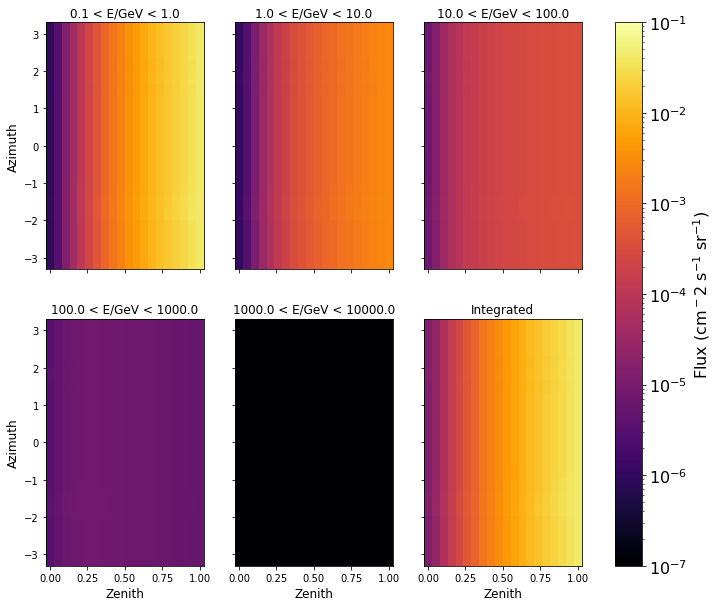

In [180]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,10), sharex=True, sharey=True)
cmap = plt.get_cmap('Blues')
for iax in range(0,len(axes.flat)-1):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosa_sample,b_sample,np.transpose(fluxmeshes[iax]),norm=mpl.colors.LogNorm(vmin=1e-7, vmax=1e-1),cmap='inferno',shading='auto')
    ax.set_title(str(EBins[iax])+ " < E/GeV < " + str(EBins[iax+1]))
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^-2$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^-2$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)
totalflux=np.zeros_like(fluxmeshes[0])
for m in fluxmeshes:
    totalflux+=m
ax=axes.flatten()[-1]
im=ax.pcolormesh(cosa_sample,b_sample,np.transpose(totalflux),norm=mpl.colors.LogNorm(vmin=1e-7, vmax=1e-1),cmap='inferno',shading='auto')
ax.set_title("Integrated")

axes[1,0].set_xlabel("Zenith",fontsize=12)
axes[1,1].set_xlabel("Zenith",fontsize=12)
axes[1,2].set_xlabel("Zenith",fontsize=12)

axes[1,0].set_ylabel("Azimuth",fontsize=12)
axes[0,0].set_ylabel("Azimuth",fontsize=12)



starting on energy 0
starting on energy 1
starting on energy 2
starting on energy 3
starting on energy 4
starting on energy 5


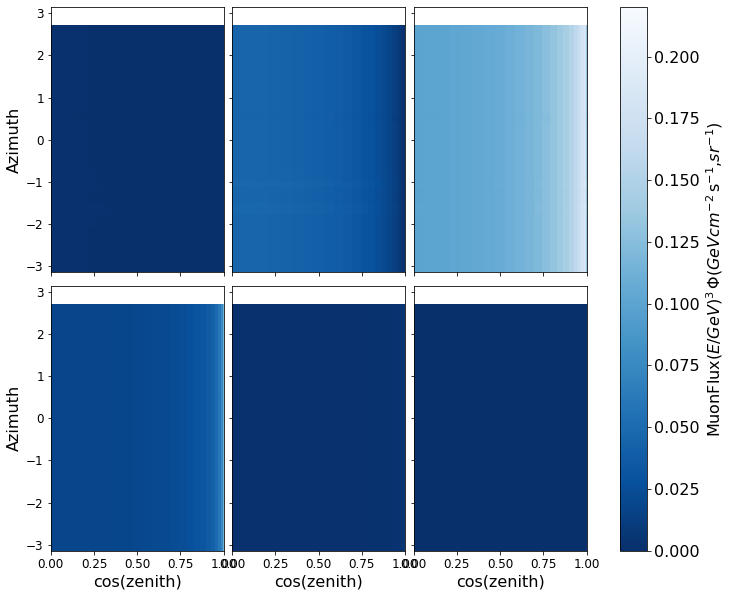

In [25]:
energies=energiesrange[5:90:15]
locs=range(0,6)
a=0

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,10), sharex=True, sharey=True)
cmap = plt.get_cmap('Blues')
for ax in axes.flat:
    
    print("starting on energy",a)
    LOC=locs[a]
    


    E=energies[LOC]

    inteAs=[]
    inteBs=[]
    inteflux=[]

    for A in alpharange[::4]:
        #print(A)
        for B in betarange[::25]:
            alp=np.deg2rad(A)
            bet=np.deg2rad(B)
            inteAs.append(np.cos(alp))
            inteBs.append(bet)

            FLUX=mussimData[(mussimData.alpha==A)&(mussimData.beta==B)&(mussimData.Energies==E)].MuFLux.iloc[0]
            inteflux.append(FLUX)


    inteflux = np.array(inteflux)
    inteflux=inteflux.reshape(len(np.unique(inteAs)), len(np.unique(inteBs)))


    im=ax.pcolormesh(np.unique(inteAs),np.unique(inteBs),np.transpose(inteflux),cmap=cmap.reversed(),shading='auto',vmin=0,vmax=.22)



    #clb=fig.colorbar(c, ax=ax)
    #clb.ax.tick_params(labelsize=18) 

    #clb.ax.set_ylabel('MuonFlux'+ r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}$) (GeV)', rotation=270,fontsize=18, labelpad=15)

    
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlim(0,1)
    ax.tick_params(axis='both', which='major', labelsize=12)
    

    #ax.legend(loc='lower right',title=str(E*10**-3)+'TeV',title_fontsize=12)

    if (LOC>2):
        ax.set_xlabel("cos(zenith)",fontsize=16)
    if (LOC==0) or (LOC==3):        
        ax.set_ylabel("Azimuth",fontsize=16)


    a+=1

fig.subplots_adjust(wspace=.05, hspace=.05)

cbar=fig.colorbar(im, ax=axes.ravel().tolist())
#cbar.set_ticks(np.arange(0, 1, 0.2))
cbar.set_label('MuonFlux'+ r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}$,$sr^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)
#fig.clim(0,1)


#fig.savefig("/Users/rogerslc/PROPOSAL/PROPOSAL/SimulatedPercents.png",dpi=250,bbox_inches='tight')

#plt.show()






In [24]:
energies=energiesrange[5:90:15]
locs=range(0,6)
a=0

for ax in axes.flat:
    print("starting on energy",a)
    LOC=locs[a]

    E=energies[LOC]

    inteAs=[]
    inteBs=[]
    inteflux=[]

    for A in alpharange[::4]:
        #print(A)
        for B in betarange[::25]:
            alp=np.deg2rad(A)
            bet=np.deg2rad(B)
            inteAs.append(np.cos(alp))
            inteBs.append(bet)

            FLUX=mussimData[(mussimData.alpha==A)&(mussimData.beta==B)&(mussimData.Energies==E)].MuFLux.iloc[0]
            inteflux.append(FLUX)


    inteflux = np.array(inteflux)
    inteflux=inteflux.reshape(len(np.unique(inteAs)), len(np.unique(inteBs)))




    a+=1

    df=pd.DataFrame(inteAs, columns = ['Alpha'])
    df['Beta']=inteBs
    df['Muflux']=inteflux

    fluxarray=np.array(df.Muflux)
    fluxarray = fluxarray.reshape(len(df.Alpha.unique()), len(df.Beta.unique()))
    FluxMuons=scipy.interpolate.RectBivariateSpline(np.unique(df.Alpha),np.unique(df.Beta),fluxarray,s=0,kx=3, ky=3)

    with open('/Users/rogerslc/MCeQ/MCeQ_Muons_interpolator'+str(np.round((E*10**-3),4))+'TeV.pkl', 'wb') as f:
        pickle.dump(FluxMuons, f)
        


starting on energy 0


ValueError: Length of values (23) does not match length of index (644)